In [2]:
import numpy as np
import pandas as pd
import tables
from glob import glob
from os.path import join, exists
from matplotlib import pyplot as plt
import re
from sstcam_simulation import Camera
from scipy.signal import find_peaks, peak_widths
from sstcam_simulation.performance.plot_lab_performance import extract_charge_resolution_mc, extract_trigger_efficiency
from tqdm.auto import tqdm
from CHECLabPy.plotting.resolutions import ChargeResolutionPlotter
from numpy.polynomial.polynomial import polyfit, polyval
%matplotlib inline

In [23]:
directory = "/Users/Jason/Software/sstcam-labbook/d200626_undershoot/cameras"
h5_paths = glob(join(directory, "*.h5"))

In [25]:
df_files = []
pattern = r".*\/undershoot_(.+)_(.+)_(.+)_lab.h5"
for h5_path in h5_paths:
    camera_path = h5_path.replace("_lab.h5", ".pkl")
    regexr = re.search(pattern, h5_path)
    ratio = float(regexr.group(1))
    sigma0 = float(regexr.group(2))
    sigma1 = float(regexr.group(3))
    
    assert exists(h5_path)
    assert exists(camera_path)
    
    camera = Camera.load(camera_path)
    x = camera.reference_pulse.time
    y = camera.reference_pulse.pulse
    sample_width = x[1] - x[0]
    
    peaks, _ = find_peaks(y)
    widths = peak_widths(y, peaks)
    pulse_width = widths[0][0] * sample_width
    
    if sigma1 == 0:
        undershoot_width = 0
    else:
        peaks, _ = find_peaks(-y)
        widths = peak_widths(-y, peaks)
        undershoot_width = widths[0][-1] * sample_width
        
    area_neg = -1 * y[y<0].sum() * sample_width
    area_pos = y[y>0].sum() * sample_width
        
    df_files.append(dict(
        h5_path=h5_path,
        camera_path=camera_path,
        ratio=ratio,
        sigma0=sigma0,
        sigma1=sigma1,
        pulse_width=pulse_width,
        undershoot_width=undershoot_width,
        measured_ratio = area_neg/area_pos,
    ))
    
df_files = pd.DataFrame(df_files).sort_values(['sigma0', 'sigma1'])

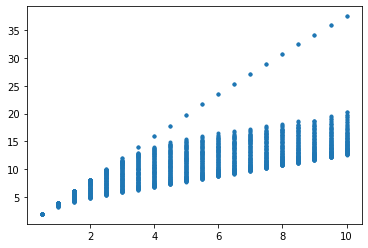

In [26]:
plt.plot(df_files['sigma0'], df_files['pulse_width'], '.')

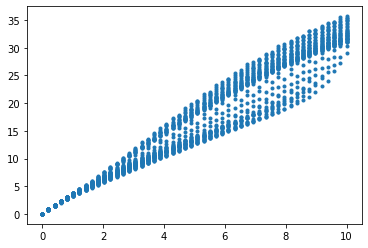

In [27]:
plt.plot(df_files['sigma1'], df_files['undershoot_width'], '.')

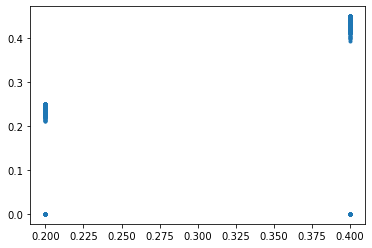

In [28]:
plt.plot(df_files['ratio'], df_files['measured_ratio'], '.')

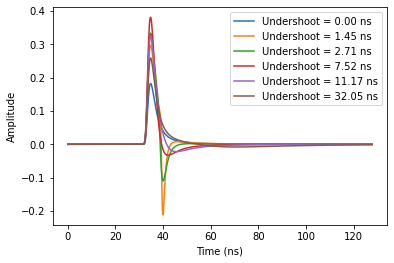

In [133]:
# Plot reference pulses
mask = (df_files['sigma0'] == 1) & (df_files['ratio'] == 0.2)
df_refpulse = df_files.loc[mask].iloc[[0, 2, 4, 10, 15, -1]]
for _, row in df_refpulse.iterrows():
    camera = Camera.load(row['camera_path'])
    x = camera.reference_pulse.time
    y = camera.reference_pulse.pulse
    label = f"Undershoot = {row['undershoot_width']:.2f} ns"
    plt.plot(x, y, label=label)

plt.legend(loc=1)
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.savefig("pulses.pdf")

In [147]:
# # Plot CR curves
# with tables.File(df_files.iloc[0]['h5_path'], mode='r') as file:
#     data = file.root.event[:]
#     measured_charge = data['measured_charge']
#     true_charge = data['true_charge']
# ref_cr_x, ref_cr_y = extract_charge_resolution_mc(measured_charge, true_charge)


# for _, row in df_files.iterrows():
#     with tables.File(row['h5_path'], mode='r') as file:
#         data = file.root.event[:]
#         measured_charge = data['measured_charge']
#         true_charge = data['true_charge']
    
#     cr_x, cr_y = extract_charge_resolution_mc(measured_charge, true_charge)
#     plt.plot(cr_x, cr_y, label=f"Undershoot = {row['undershoot_width']:.2f} ns")

# plt.legend(loc='best')
# plt.xscale('log')
# plt.yscale('log')

In [41]:
# Extract performance
df_all_ratio_list = []
for _, row in tqdm(df_files.iterrows(), total=df_files.index.size):
    with tables.File(row['h5_path'], mode='r') as file:
        data = file.root.event[:]
        illumination = data['illumination']
        n_triggers = data['n_triggers']
        measured_charge = data['measured_charge']
        true_charge = data['true_charge']
        
    # Calibrate charge
    mask = (true_charge >= 50) & (true_charge <=500)
    coeff = polyfit(true_charge[mask], measured_charge[mask], [1])
    measured_charge /= coeff[1]
    coeff = polyfit(true_charge[mask], measured_charge[mask], [1])

    teff_x, teff_y, teff_yerr = extract_trigger_efficiency(illumination, n_triggers)
    teff_50 = np.interp(0.5, teff_y, teff_x)
    
    cr_x, cr_y = extract_charge_resolution_mc(measured_charge, true_charge)
    cr_2pe = np.interp(2, cr_x, cr_y)
    cr_100pe = np.interp(100, cr_x, cr_y)
        
    df_all_ratio_list.append(dict(
        ratio=row['ratio'],
        sigma0=row['sigma0'],
        sigma1=row['sigma1'],
        pulse_width=row['pulse_width'],
        undershoot_width=row['undershoot_width'],
        teff_50=teff_50,
        cr_2pe=cr_2pe,
        cr_100pe=cr_100pe,
    ))

In [52]:
#df_all_ratio = pd.DataFrame(df_all_ratio_list)
df_all_ratio = df_all_ratio.loc[df_all_ratio['pulse_width'] <= 20]

In [53]:
# Extract requirements
true = np.geomspace(1, 1000)
crreq = ChargeResolutionPlotter.requirement(true)
crreq_2pe = np.interp(2, true, crreq)
crreq_100pe = np.interp(100, true, crreq)
print(crreq_2pe, crreq_100pe)

checs_ratio = 0.20581828565154767
checs_pulse_width = 10.650883938789999
checs_undershoot_width = 19.880996171267505

1.1809228716436992 0.1572348562845242


# 20% Undershoot

In [54]:
df = df_all_ratio.loc[df_all_ratio['ratio'] == 0.2]

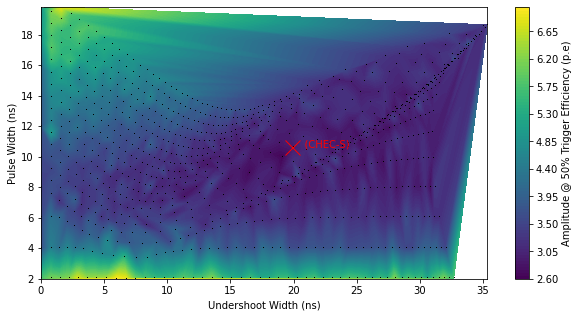

In [144]:
fig, ax = plt.subplots(figsize=(10, 5))
c = ax.tricontourf(df['undershoot_width'], df['pulse_width'], df['teff_50'], 100)
ax.plot(df['undershoot_width'], df['pulse_width'], ',', c='black')
ax.plot(checs_undershoot_width, checs_pulse_width, 'x', c='red', ms=15)
ax.text(checs_undershoot_width, checs_pulse_width, "    (CHEC-S)", color='red')
ax.set_xlabel("Undershoot Width (ns)")
ax.set_ylabel("Pulse Width (ns)")
fig.colorbar(c, ax=ax, label="Amplitude @ 50% Trigger Efficiency (p.e)")
plt.savefig("teff_50.png", dpi=300)

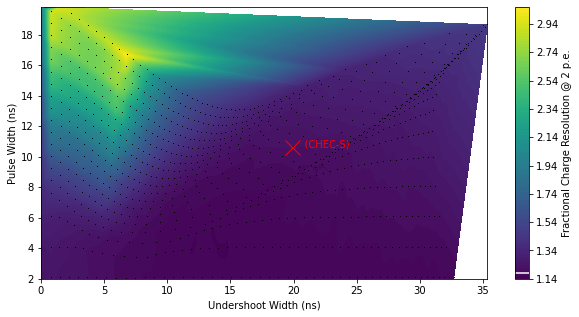

In [145]:
fig, ax = plt.subplots(figsize=(10, 5))
df_2pe = df
c = ax.tricontourf(df['undershoot_width'], df['pulse_width'], df['cr_2pe'], 100)
ax.plot(df['undershoot_width'], df['pulse_width'], ',', c='black')
ax.plot(checs_undershoot_width, checs_pulse_width, 'x', c='red', ms=15)
ax.text(checs_undershoot_width, checs_pulse_width, "    (CHEC-S)", color='red')
ax.set_xlabel("Undershoot Width (ns)")
ax.set_ylabel("Pulse Width (ns)")
cb = fig.colorbar(c, ax=ax, label="Fractional Charge Resolution @ 2 p.e.")
cb.ax.plot([0, 10], [crreq_2pe, crreq_2pe], 'w')
plt.savefig("cr_2pe.png", dpi=300)

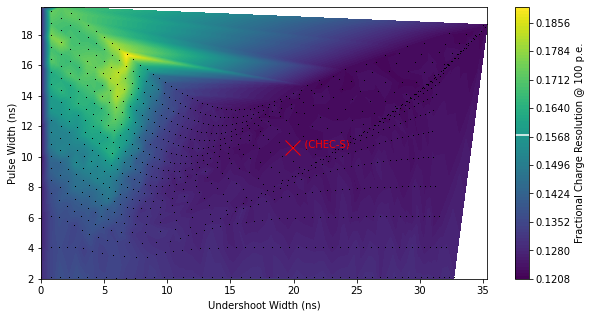

In [146]:
fig, ax = plt.subplots(figsize=(10, 5))
c = ax.tricontourf(df['undershoot_width'], df['pulse_width'], df['cr_100pe'], 100)
ax.plot(df['undershoot_width'], df['pulse_width'], ',', c='black')
ax.plot(checs_undershoot_width, checs_pulse_width, 'x', c='red', ms=15)
ax.text(checs_undershoot_width, checs_pulse_width, "    (CHEC-S)", color='red')
ax.set_xlabel("Undershoot Width (ns)")
ax.set_ylabel("Pulse Width (ns)")
cb = fig.colorbar(c, ax=ax, label="Fractional Charge Resolution @ 100 p.e.")
cb.ax.plot([0, 10], [crreq_100pe, crreq_100pe], 'w')
plt.savefig("cr_100pe.png", dpi=300)

# 40% Undershoot

In [148]:
df = df_all_ratio.loc[df_all_ratio['ratio'] == 0.4]

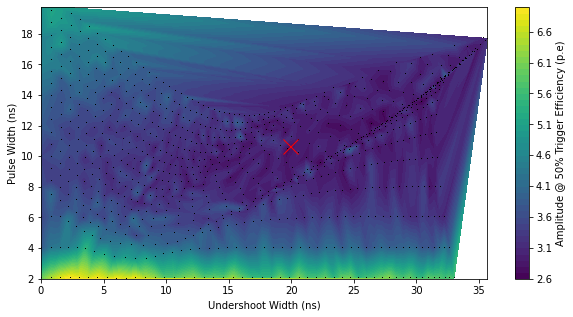

In [149]:
fig, ax = plt.subplots(figsize=(10, 5))
c = ax.tricontourf(df['undershoot_width'], df['pulse_width'], df['teff_50'], 50)
ax.plot(df['undershoot_width'], df['pulse_width'], ',', c='black')
ax.plot(checs_undershoot_width, checs_pulse_width, 'x', c='red', ms=15)
ax.set_xlabel("Undershoot Width (ns)")
ax.set_ylabel("Pulse Width (ns)")
fig.colorbar(c, ax=ax, label="Amplitude @ 50% Trigger Efficiency (p.e)")

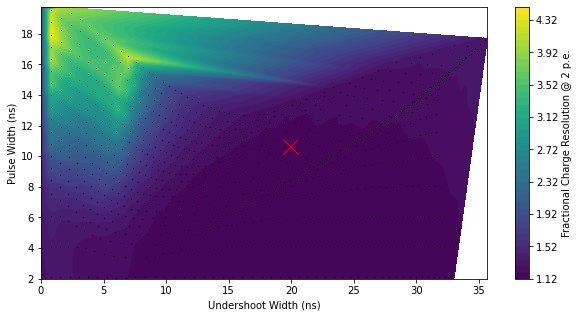

In [150]:
fig, ax = plt.subplots(figsize=(10, 5))
c = ax.tricontourf(df['undershoot_width'], df['pulse_width'], df['cr_2pe'], 50)
ax.plot(df['undershoot_width'], df['pulse_width'], ',', c='black')
ax.plot(checs_undershoot_width, checs_pulse_width, 'x', c='red', ms=15)
ax.set_xlabel("Undershoot Width (ns)")
ax.set_ylabel("Pulse Width (ns)")
fig.colorbar(c, ax=ax, label="Fractional Charge Resolution @ 2 p.e.")

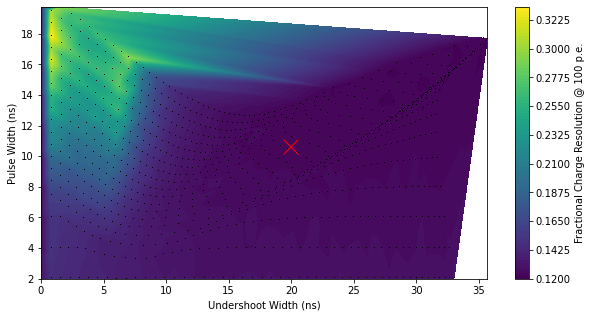

In [151]:
fig, ax = plt.subplots(figsize=(10, 5))
c = ax.tricontourf(df['undershoot_width'], df['pulse_width'], df['cr_100pe'], 100)
ax.plot(df['undershoot_width'], df['pulse_width'], ',', c='black')
ax.plot(checs_undershoot_width, checs_pulse_width, 'x', c='red', ms=15)
ax.set_xlabel("Undershoot Width (ns)")
ax.set_ylabel("Pulse Width (ns)")
fig.colorbar(c, ax=ax, label="Fractional Charge Resolution @ 100 p.e.")